# 实验一： 中国股市收益率的分布特征

1. 认真阅读三篇文献资料（自己也可以下载相关文献进行阅读），了解股票市场收益率分布的重要性和形态特征，重点关注收益率分布的研究思路和研究方法。

2. 在阅读文献的基础上，结合提供的上证指数分钟数据，尝试完成如下计算：

（1）根据上证指数分钟数据，分布计算不同时间尺度（1分钟、5分钟、10分钟、30分钟、60分钟、120分钟、240分钟）的收益率序列；

（2）计算不同尺度收益率的经验概率密度，并画在同一幅图上，比较不同尺度收益率分布的区别；

（3）计算不同尺度收益率的正态拟合分布，比较他们对正态分布偏离程度；

（4）考察不同尺度收益率的尾部分布特征，是否满足幂律分布？是否服从“负三次方定律”？

提示一：经验概率分布计算：将分析样本覆盖的范围分成若干区间，即[r0, r1] ∪ [r1, r2] ∪ [r2, r3] ∪ [r3, r5] ∪ … ∪ [ri-1, ri] ∪ … ∪ [rn-1, rn]，再分别计算每个区间内的样本个数yi，进而计算概率pi=yi/(ri-ri-1)/m，其中m为样本总个数。画图时，区间概率pi对应ri可以用区间的中点表示。为了使经验概率分布图形美观，若画图使用线性坐标（x轴），可以线性均分样本范围；若画图使用对数坐标（x轴），可对数等分样本范围。分割的份数自主选择，一般以画图美观为准。

提示二：所有图形按照画图标准流程（画图、修饰、输出）进行。

## 导包与全局画图参数初始化

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from scipy.stats import norm, kstest
import powerlaw
from scipy.optimize import curve_fit

import shutup
shutup.please()

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

## 加载matlab数据：Shanghai Stock Exchange Composite Index, SSEC

先进行价格数据的读取，这里matlab存的是分钟级的数据

In [2]:
# 读取上证指数分钟数据并进行预处理
# 加载MATLAB格式的分钟数据
mat_data = loadmat('./data/SSEC_min.mat')
mat_data = mat_data['p']
mat_data = mat_data[:, 0]  # 保留第一列

# 转换成df美观输出，看看数据是什么
mat_df = pd.DataFrame(mat_data)
mat_df.head()

,0
0,1348.130
1,1318.918
2,1318.436
3,1336.889
4,1336.046


In [3]:
# 接着对数据进行处理
# 删除价格为0的异常数据点
mark = mat_data != 0  # 数据不为0，则mark=ture，之后过滤的时候保留
mat_data = mat_data[mark]

# 再看看处理后的数据
print(f"加载的数据点数量: {len(mat_data)}")
print()
print(f"数据范围: {mat_data.min()} - {mat_data.max()}")
print()
print(f"前10个数据点: {mat_data[:10]}")

加载的数据点数量: 715138

数据范围: 998.337 - 6122.674

前10个数据点: [1348.13   1318.918  1318.436  1336.889  1336.046  1504.64   1504.579
 1504.551  1504.396  1503.8979]


接下来，我们需要基于价格数据来计算收益率

In [4]:
scales = [1, 5, 10, 30, 60, 120, 240] # 时间尺度，单位：分钟

# 计算的收益率，我们用hash存
r_res = {}

for scale in scales:
    # 对数收益率
    # 这里采用的是直接用数组计算
    r = np.log(mat_data[scale:]) - np.log(mat_data[:-scale])
    
    # 过滤掉极端值，只保留-0.1到0.1之间的收益率（涨跌停）
    r_filter = []
    for value in r:
        if value >= -0.1 and value <= 0.1:
            r_filter.append(value)
    
    r_filter = np.array(r_filter) # 将结果转换为np数组

    # 创建hash的键名
    # minute_r_1 表示一分钟收益率
    key_name = "minute_r_" + str(scale)

    r_res[key_name] = r_filter

# 看看收益率的计算结果
r_res

{'minute_r_1': array([-2.19067435e-02, -3.65517868e-04,  1.38990874e-02, ...,
         7.23287659e-05,  2.09065593e-05, -1.16969341e-04]),
 'minute_r_5': array([-0.00045869, -0.00052121, -0.0003244 , ..., -0.00104677,
        -0.00040251, -0.00020342]),
 'minute_r_10': array([-0.00136471, -0.00142334, -0.00151056, ..., -0.00237772,
        -0.00274964, -0.00286492]),
 'minute_r_30': array([-0.00089164, -0.00052254, -0.00069214, ..., -0.00666564,
        -0.00692394, -0.00774517]),
 'minute_r_60': array([ 0.00111128,  0.0012182 ,  0.00130645, ..., -0.00730503,
        -0.00735312, -0.00726955]),
 'minute_r_120': array([ 0.00460775,  0.00461323,  0.00431694, ..., -0.00321532,
        -0.00241882, -0.00300662]),
 'minute_r_240': array([ 0.00509586,  0.00515227,  0.00553581, ..., -0.00799307,
        -0.00822129, -0.00855708])}

In [5]:
# 接下来对计算出的收益率进行描述性统计

from IPython.display import display

# 描述性统计表格
stats_df = pd.DataFrame(index=['样本数量', '均值', '标准差', '最小值', '最大值', '峰度'])

for scale in scales:
    key = f"minute_r_{scale}"
    r = r_res[key]
    
    # 计算峰度
    kurtosis = ((r - r.mean())**4).mean() / (r.std()**4)

    stats = {
        '样本数量': len(r),
        '均值': r.mean(),
        '标准差': r.std(),
        '最小值': r.min(),
        '最大值': r.max(),
        '峰度': kurtosis
    }
    
    stats_df[f"{scale}分钟"] = pd.Series(stats)

# 设置数值格式，保留6位小数
pd.options.display.float_format = '{:.6f}'.format

display(stats_df)

,1分钟,5分钟,10分钟,30分钟,60分钟,120分钟,240分钟
样本数量,715134.000000,715126.000000,715121.000000,715101.000000,715069.000000,714869.000000,714184.000000
均值,0.000001,0.000006,0.000012,0.000036,0.000072,0.000137,0.000265
标准差,0.000870,0.002458,0.003431,0.005873,0.008382,0.011904,0.017273
最小值,-0.072993,-0.085314,-0.084823,-0.083035,-0.099338,-0.099777,-0.099986
最大值,0.087230,0.089191,0.090334,0.093732,0.096923,0.099943,0.100000
峰度,1285.959033,95.507920,51.120683,22.270254,14.977232,9.785231,6.652913


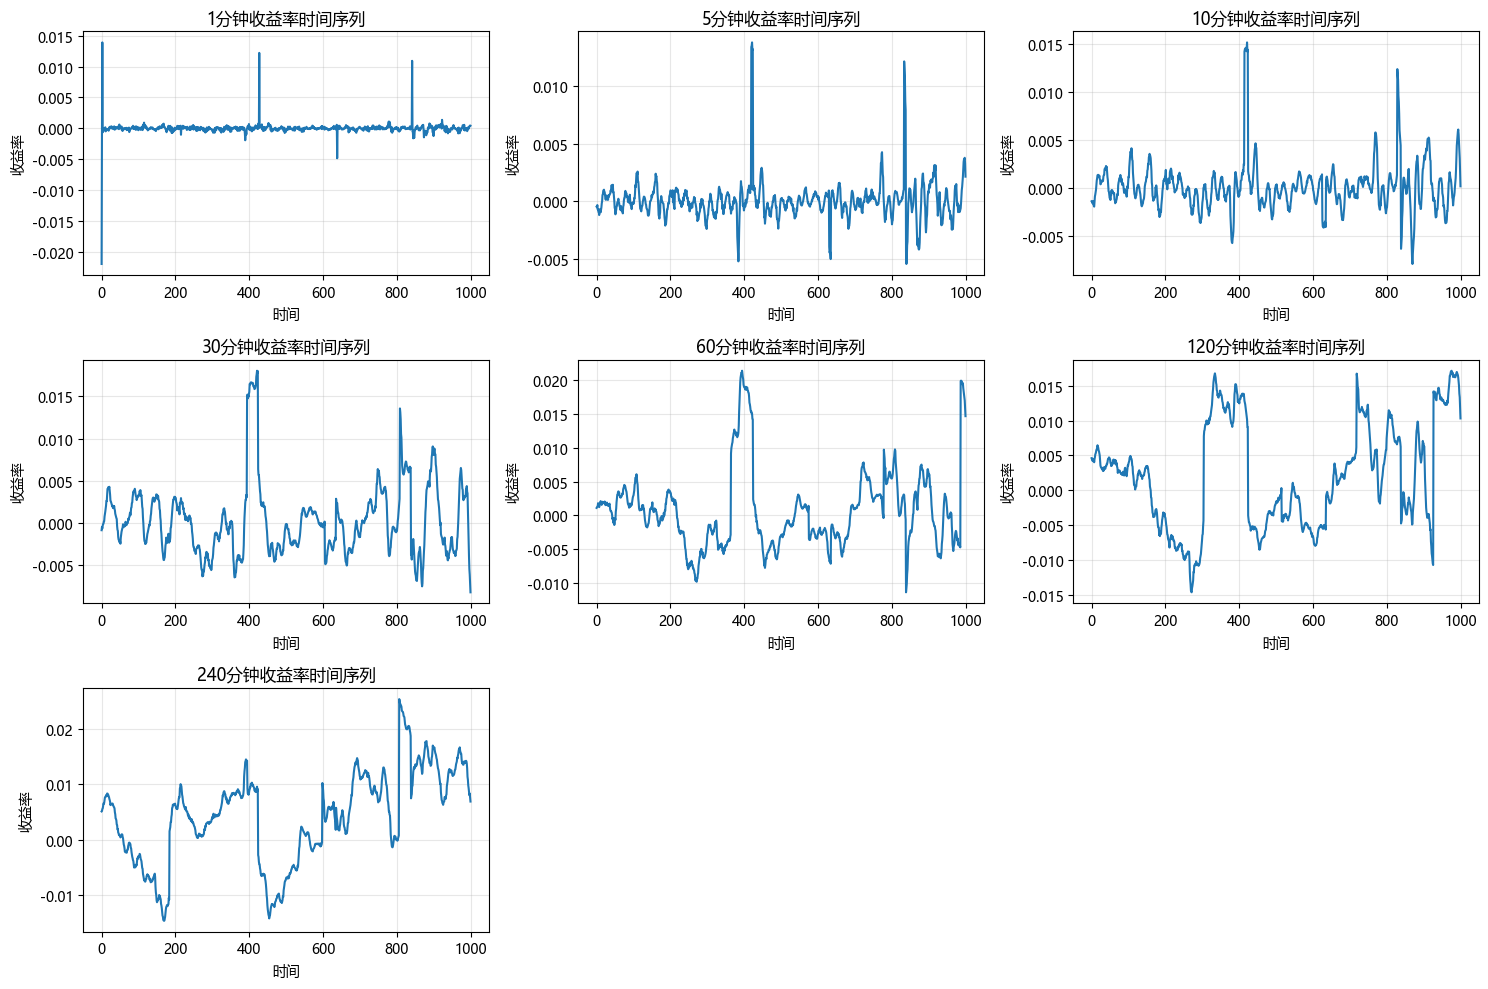

In [6]:
# 最后我们可视化这些数据
plt.figure(figsize=(15, 10))

for i, scale in enumerate(scales):
    returns = r_res[f'minute_r_{scale}']
    
    # 计算子图位置（3行3列的布局）
    plt.subplot(3, 3, i+1)
    
    # 绘制前1000个数据点
    plot_len = min(1000, len(returns))
    plt.plot(returns[:plot_len])

    plt.title(f'{scale}分钟收益率时间序列')
    plt.xlabel('时间')
    plt.ylabel('收益率')
    plt.grid(True, alpha=0.3)

# 优化图表布局
plt.tight_layout()
plt.show()

## 经验概率密度计算

### 经验概率密度的概念

经验概率密度是一种统计概念，它帮助我们了解数据集中的值是如何分布的，而不需要对潜在的理论分布做任何假设。这是一种数据驱动的方法，用于估计随机变量的概率密度函数。

经验概率密度函数（PDF）是根据观察到的数据来近似随机变量真实概率分布的方法。与有预定义数学公式的理论分布（如正态分布、指数分布等）不同，经验PDF直接从数据集构建。

可以将其想象为被归一化的直方图，其下的总面积等于1，这使它可以被解释为概率分布。

### 经验概率密度的计算方法

#### 第一步：将数据范围分成多个区间

首先，将数据的完整范围分成若干个区间或"箱"。例如，如果数据范围从-0.1到0.1，可以创建诸如`[-0.1, -0.08]`、`[-0.08, -0.06]`等区间。

#### 第二步：计算每个区间内的样本数

对于每个区间`[r₁, r₂]`，计算落在这个范围内的数据点数量，记为 $y_i$。

#### 第三步：计算概率密度

对于每个区间，使用以下公式计算概率密度：

$p_i = y_i / (r_i - r_(i-1)) / m$

其中：
- $y_i$是区间i内的样本数
- $(r_i - r_(i-1))$是区间的宽度
- m是数据集中的总样本数

通过区间宽度进行除法运算可以标准化不同大小的区间，而除以总样本数则确保总概率等于1。

#### 第四步：关联到点
为了绘图目的，每个概率密度值$p_i$通常与其区间的中点$(r_(i-1) + r_i)/2$相关联。

### 在股市分析中的应用

在股市收益率分析中，这种方法允许我们：

1. **直观展示不同时间尺度的收益率分布**：从分钟级到日级，观察分布形态的变化。

2. **与理论分布比较**：检验收益率是否符合正态分布假设，通常结果表明收益率显著偏离正态分布。

3. **研究尾部行为**：识别"胖尾"或极端事件发生的概率，这通常比正态分布预测的要高。

4. **分析标度不变性**：通过Hurst指数等方法，检验不同时间尺度下分布的自相似性。

In [7]:
# 经验概率密度的计算函数
# 参数：需要计算的数据，以及划分为num_bin - 1个区间
def calc_empirical_probability(data, num_bin):
    # 先对数据进行分区
    bin = np.linspace(np.min(data), np.max(data), num_bin)
    
    # 初始化结果数组
    x_emp = np.zeros(len(bin) - 1)
    y_emp = np.zeros(len(bin) - 1)
    
    for i in range(len(bin) - 1):
        # 计算区间中点
        x_emp[i] = (bin[i] + bin[i+1]) / 2
        # 计算区间概率密度
        y_emp[i] = np.sum((data >= bin[i]) & (data < bin[i+1])) / len(data) / (bin[i+1] - bin[i])
    
    # 只保留概率密度大于0的点
    mark = y_emp > 0
    x_emp = x_emp[mark]
    y_emp = y_emp[mark]
    
    # x_emp - 横坐标值（区间中点）
    # y_emp - 纵坐标值（概率密度）
    return x_emp, y_emp

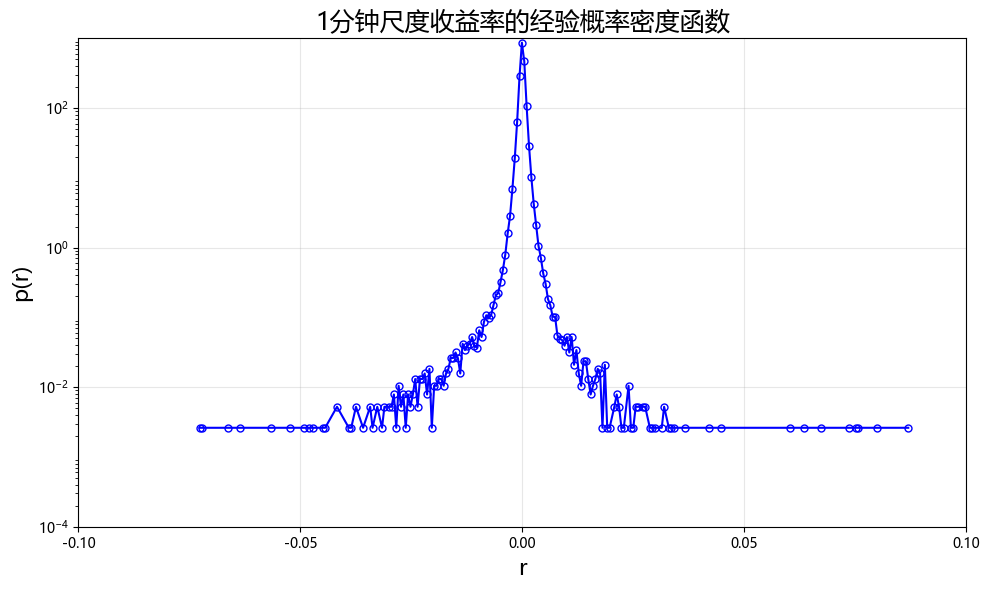

In [8]:
# 我们以一分钟为例，展示下经验概率密度的计算以及结果
minute_r_1 = r_res['minute_r_1']
# 301 是经验数，这么做出来效果大概率还行
x, y = calc_empirical_probability(minute_r_1, 301)

plt.figure(figsize=(10, 6))
plt.semilogy(x, y, 'o-b', lw=1.5, ms=5, mfc='none', label='1分钟尺度')
plt.xlim([-0.1, 0.1])
plt.xticks([-0.1, -0.05, 0, 0.05, 0.1])
plt.ylim([10. ** -4, 10 ** 3])
plt.yticks(10. ** np.arange(-4, 4, 2))
plt.xlabel('r', fontsize=16)
plt.ylabel('p(r)', fontsize=16)
plt.title('1分钟尺度收益率的经验概率密度函数', fontsize=18)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
print(f"横坐标点数: {len(x)}")
print()
print(f"概率密度最大值: {y.max():.4f} 位于收益率: {x[np.argmax(y)]:.6f}")

横坐标点数: 146

概率密度最大值: 865.2459 位于收益率: -0.000091


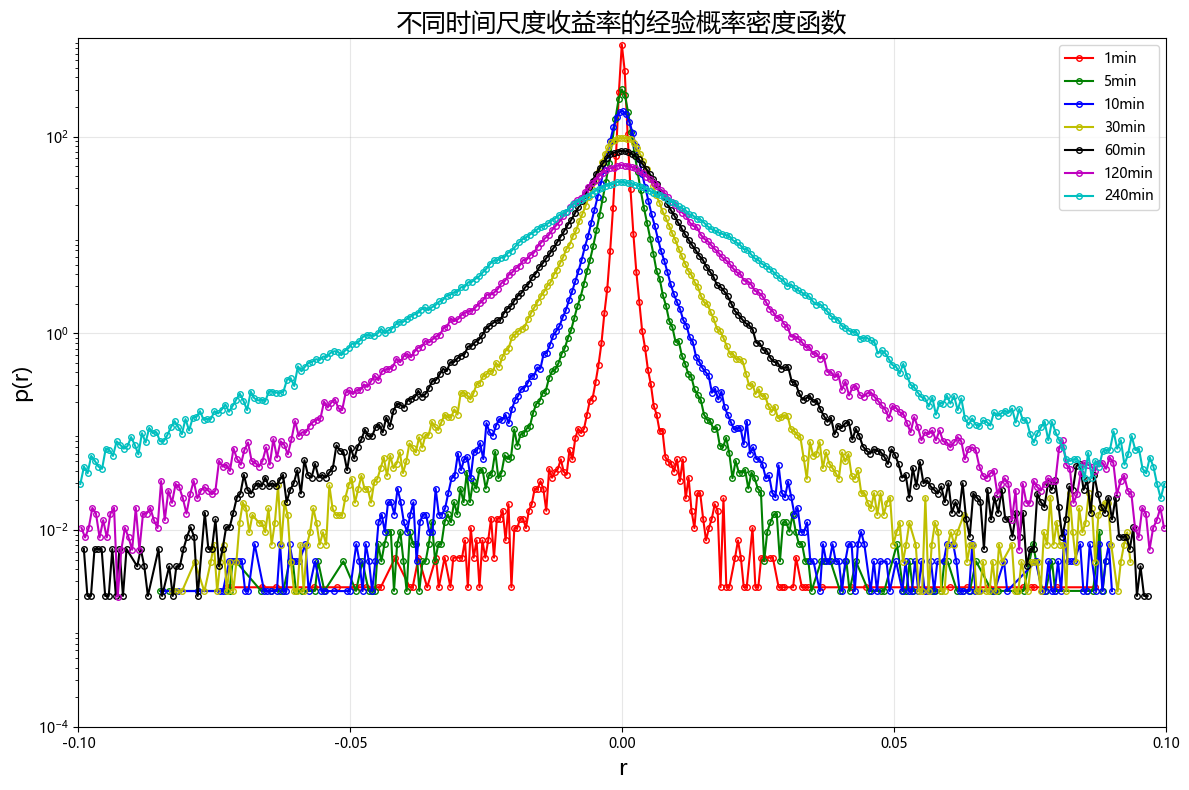

In [10]:
# 绘制所有时间尺度的经验概率密度函数
plt.figure(figsize=(12, 8))
colors = ['r', 'g', 'b', 'y', 'k', 'm', 'c']

# 保存所有尺度的x_emp和y_emp结果
x_emp_res = {}
y_emp_res = {}

for i, (key, returns) in enumerate(r_res.items()):
    x_emp, y_emp = calc_empirical_probability(returns, num_bin=301)
    x_emp_res[key] = x_emp
    y_emp_res[key] = y_emp
    scale = key.replace('minute_r_', '')
    
    # 使用半对数坐标系绘制
    plt.semilogy(x_emp, y_emp, '-', color=colors[i], lw=1.5, marker='o', ms=4, mfc='none', label=f'{scale}min')

plt.xlim([-0.1, 0.1])
plt.xticks([-0.1, -0.05, 0, 0.05, 0.1])
plt.ylim([10. ** -4, 10 ** 3])
plt.yticks(10. ** np.arange(-4, 4, 2))
plt.xlabel('r', fontsize=16)
plt.ylabel('p(r)', fontsize=16)
plt.title('不同时间尺度收益率的经验概率密度函数', fontsize=18)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

 1分钟尺度峰度: 1285.9590
 5分钟尺度峰度: 95.5079
 10分钟尺度峰度: 51.1207
 30分钟尺度峰度: 22.2703
 60分钟尺度峰度: 14.9772
 120分钟尺度峰度: 9.7852
 240分钟尺度峰度: 6.6529


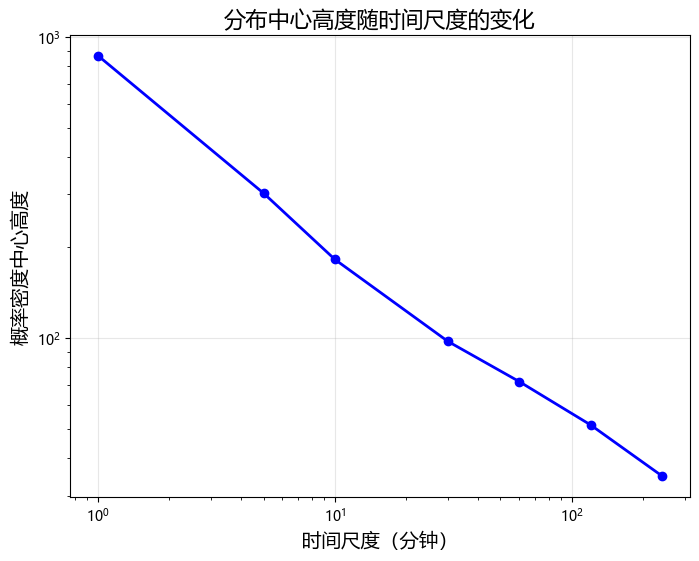

In [11]:
# 分析不同时间尺度分布的峰度变化
for key, returns in r_res.items():
    scale = key.replace('minute_r_', '')
    kurtosis = ((returns - returns.mean())**4).mean() / (returns.std()**4)
    print(f" {scale}分钟尺度峰度: {kurtosis:.4f}")

# 分析分布的中心高度随时间尺度的变化
center_heights = []
for key, y_emp in y_emp_res.items():
    scale = int(key.replace('minute_r_', ''))
    x_emp = x_emp_res[key]
    # 找到最接近0的位置
    center_idx = np.argmin(np.abs(x_emp))
    center_heights.append((scale, y_emp[center_idx]))

scales = [t[0] for t in center_heights]
heights = [t[1] for t in center_heights]

plt.figure(figsize=(8, 6))
plt.loglog(scales, heights, 'o-b', lw=2)
plt.title('分布中心高度随时间尺度的变化', fontsize=16)
plt.xlabel('时间尺度（分钟）', fontsize=14)
plt.ylabel('概率密度中心高度', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


从图表可以看出，随着时间尺度增加，分布中心高度减小，表明分布逐渐变得平缓

## 计算不同尺度收益率的正态拟合分布，并比较偏离程度

#### 函数原理与目标

`fit_normal_distribution` 函数的核心目的是检验股票收益率分布是否遵循正态分布，这是金融学中的一个重要问题。传统的金融理论（如有效市场假说和Black-Scholes模型）假设资产收益率服从正态分布，但实际市场数据通常显示出偏离正态的特征，尤其是"尖峰厚尾"现象。

### 数学基础

#### 正态分布

正态分布（也称高斯分布）由两个参数定义：
- μ（均值）：分布的中心位置
- σ（标准差）：分布的宽度或波动程度

正态分布的概率密度函数为：

$$f(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

#### 参数估计

代码中的 `norm.fit(returns)` 使用最大似然估计法找到最能够拟合观测数据的μ和σ值。对于正态分布，最大似然估计等价于：
- μ = 样本平均值
- σ = 样本标准差

#### Kolmogorov-Smirnov检验

KS检验是一种非参数统计检验，用于比较样本分布与参考分布（本例中为正态分布）的一致性。其基本原理是：

1. 计算经验累积分布函数 $F_n(x)$ （基于观测数据）
2. 计算参考分布的累积分布函数 $F(x)$ （基于拟合的正态分布）
3. 计算二者间的最大差距： $D_n = \sup_x |F_n(x) - F(x)|$

KS检验的结果包括：
- 统计量：最大差距 $D_n$，越大表示偏离越明显
- p值：在原假设（样本来自正态分布）下，观察到至少这么大差距的概率
  - 小p值（通常<0.05）意味着可以拒绝"数据服从正态分布"的假设

### 股票市场收益率分布的特殊性及统计学意义

金融市场收益率分布通常具有以下特征：

1. **尖峰（Leptokurtosis）**：分布中心比正态分布更尖锐，表现为小幅波动出现的频率高于正态预期。

2. **厚尾（Fat-tails）**：极端收益率（大幅上涨或下跌）出现的概率高于正态分布预测。这意味着使用正态分布会严重低估市场风险。

3. **不对称性（Skewness）**：正负收益率的分布可能不对称，股票市场通常表现为负偏（极端负收益率的概率高于极端正收益率）。

对正态分布偏离程度的量化分析具有重要的实际意义：

- **风险管理**：准确估计极端事件概率对金融机构风险控制至关重要
- **投资策略设计**：了解收益率的真实分布特性有助于构建更稳健的投资组合
- **衍生品定价**：传统金融衍生品定价模型多基于正态分布假设，了解实际偏离程度有助于调整模型
- **市场微观结构研究**：不同时间尺度上的分布特性变化反映了市场微观结构的特征

对代码结果的解读：如果KS检验p值极低（接近0），表明收益率分布显著不同于正态分布，这会导致传统金融理论和模型在应用时产生系统性偏差，需要采用更复杂的分布（如t分布、Lévy分布或混合高斯分布）来更准确地描述市场行为。

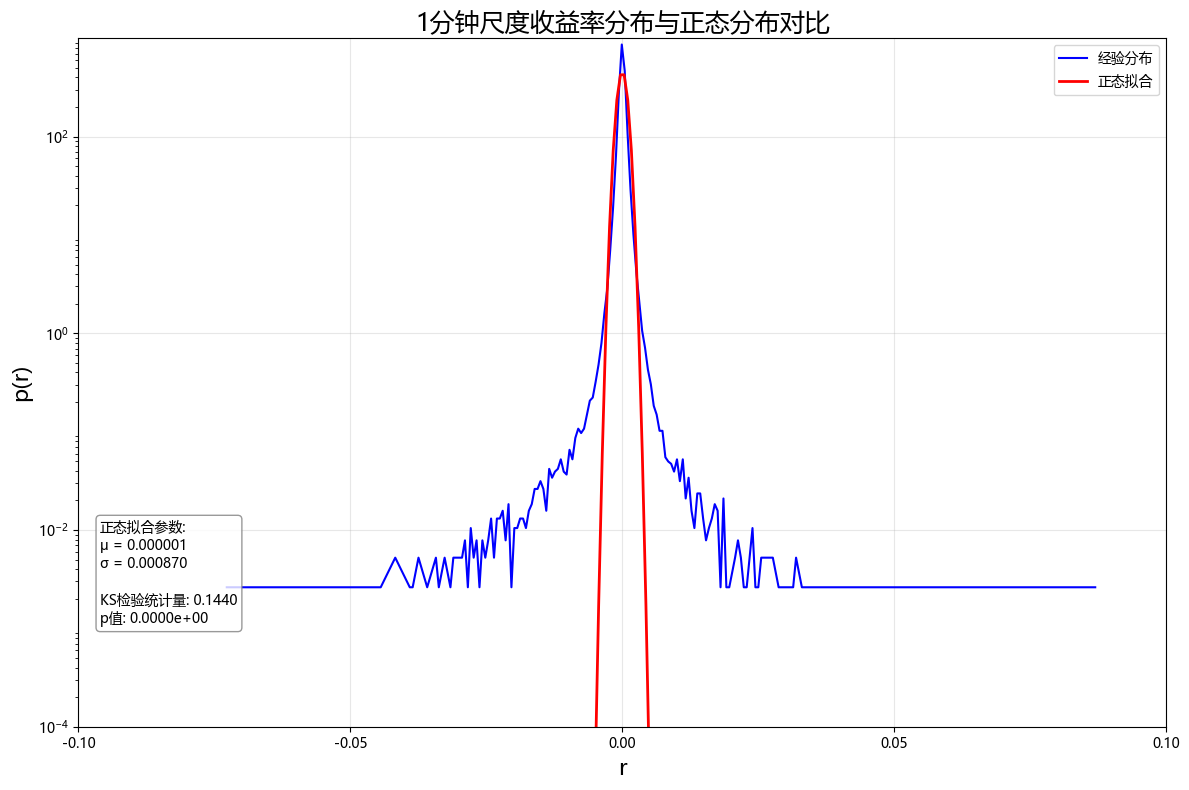

1分钟尺度收益率的正态拟合结果:
  均值: 0.000001
  标准差: 0.000870
  KS检验统计量: 0.1440
  p值: 0.0000e+00
  结论: 1分钟尺度收益率分布显著不同于正态分布


In [12]:
# 对收益率进行正态分布拟合，并与经验分布进行比较
def fit_normal_distribution(returns, x_emp, y_emp, scale):
    # 正态分布拟合
    mu, sigma = norm.fit(returns) # μ, σ
    x_fit = np.linspace(-0.1, 0.1, 300)
    y_fit = norm.pdf(x_fit, loc=mu, scale=sigma)
    
    # 绘制经验分布和正态拟合分布的对比图
    plt.figure(figsize=(12, 8))
    plt.semilogy(x_emp, y_emp, '-', color='blue', lw=1.5, ms=5, mfc='none', label='经验分布')
    plt.semilogy(x_fit, y_fit, '-', color='red', lw=2, label='正态拟合')
    
    plt.xlim([-0.1, 0.1])
    plt.xticks([-0.1, -0.05, 0, 0.05, 0.1])
    plt.ylim([10. ** -4, 10 ** 3])
    plt.yticks(10. ** np.arange(-4, 4, 2))
    plt.xlabel('r', fontsize=16)
    plt.ylabel('p(r)', fontsize=16)
    plt.title(f'{scale}分钟尺度收益率分布与正态分布对比', fontsize=18)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # 进行KS检验，判断收益率分布与正态分布的拟合程度
    ks_statistic, p_value = kstest(returns, 'norm', args=(mu, sigma))
    
    plt.annotate(f'正态拟合参数:\nμ = {mu:.6f}\nσ = {sigma:.6f}\n\nKS检验统计量: {ks_statistic:.4f}\np值: {p_value:.4e}', 
                 xy=(0.02, 0.15), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'mu': mu,
        'sigma': sigma,
        'ks_statistic': ks_statistic,
        'p_value': p_value
    }

# 对1分钟尺度的收益率进行正态分布拟合
scale = '1'
returns = r_res[f'minute_r_{scale}']
x_emp = x_emp_res[f'minute_r_{scale}']
y_emp = y_emp_res[f'minute_r_{scale}']

fit_result_1min = fit_normal_distribution(returns, x_emp, y_emp, scale)
print(f"1分钟尺度收益率的正态拟合结果:")
print(f"  均值: {fit_result_1min['mu']:.6f}")
print(f"  标准差: {fit_result_1min['sigma']:.6f}")
print(f"  KS检验统计量: {fit_result_1min['ks_statistic']:.4f}")
print(f"  p值: {fit_result_1min['p_value']:.4e}")
if fit_result_1min['p_value'] < 0.05:
    print("  结论: 1分钟尺度收益率分布显著不同于正态分布")
else:
    print("  结论: 不能拒绝1分钟尺度收益率服从正态分布的假设")

可以看到，p值基本为0，所以1分钟的收益率显然不是正太分布，我们拒绝了原假设。

### 代码实现步骤详解

1. **正态分布参数估计**：
   ```python
   mu, sigma = norm.fit(returns)  # μ, σ
   ```
   这行代码通过最大似然估计来确定最适合数据的正态分布参数。

2. **生成理论正态分布点**：
   ```python
   x_fit = np.linspace(-0.1, 0.1, 300)
   y_fit = norm.pdf(x_fit, loc=mu, scale=sigma)
   ```
   这两行代码在区间[-0.1, 0.1]上生成300个点，并计算拟合后的正态分布在这些点上的概率密度值。区间选择基于股票收益率的典型范围。

3. **执行KS检验**：
   ```python
   ks_statistic, p_value = kstest(returns, 'norm', args=(mu, sigma))
   ```
   这行代码对实际收益率数据与拟合的正态分布进行KS检验。`args=(mu, sigma)`指定了要比较的是参数为μ和σ的正态分布。

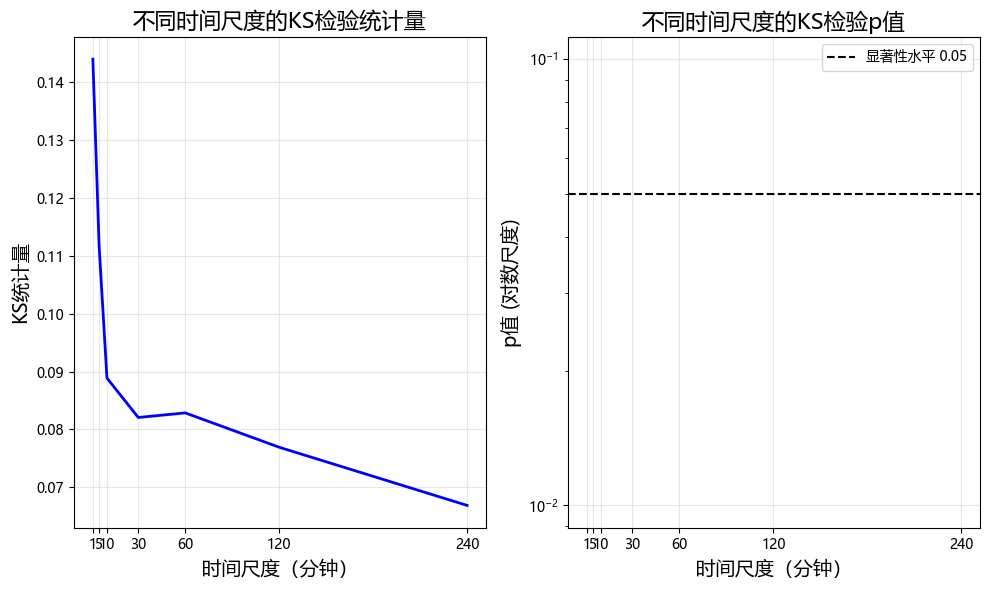

所有时间尺度收益率的正态拟合结果汇总:

1分钟尺度:
 均值: 0.000001
 标准差: 0.000870
 KS检验统计量: 0.1440
 p值: 0.0000e+00
 结论: 该尺度收益率分布显著不同于正态分布

5分钟尺度:
 均值: 0.000006
 标准差: 0.002458
 KS检验统计量: 0.1116
 p值: 0.0000e+00
 结论: 该尺度收益率分布显著不同于正态分布

10分钟尺度:
 均值: 0.000012
 标准差: 0.003431
 KS检验统计量: 0.0889
 p值: 0.0000e+00
 结论: 该尺度收益率分布显著不同于正态分布

30分钟尺度:
 均值: 0.000036
 标准差: 0.005873
 KS检验统计量: 0.0821
 p值: 0.0000e+00
 结论: 该尺度收益率分布显著不同于正态分布

60分钟尺度:
 均值: 0.000072
 标准差: 0.008382
 KS检验统计量: 0.0829
 p值: 0.0000e+00
 结论: 该尺度收益率分布显著不同于正态分布

120分钟尺度:
 均值: 0.000137
 标准差: 0.011904
 KS检验统计量: 0.0769
 p值: 0.0000e+00
 结论: 该尺度收益率分布显著不同于正态分布

240分钟尺度:
 均值: 0.000265
 标准差: 0.017273
 KS检验统计量: 0.0669
 p值: 0.0000e+00
 结论: 该尺度收益率分布显著不同于正态分布

分析随着时间尺度增加，分布向正态分布靠近的趋势:
KS统计量随时间尺度变化不呈现单调趋势，可能存在临界时间尺度


In [13]:
# 对所有时间尺度的收益率进行正态分布拟合
ks_results = {}
for key, returns in r_res.items():
    scale = key.replace('minute_r_', '')
    x_emp = x_emp_res[key]
    y_emp = y_emp_res[key]
    
    # 正态分布拟合
    mu, sigma = norm.fit(returns)
    ks_statistic, p_value = kstest(returns, 'norm', args=(mu, sigma))
    ks_results[scale] = {
        'mu': mu,
        'sigma': sigma,
        'ks_statistic': ks_statistic,
        'p_value': p_value
    }

# 汇总KS检验结果
scales = [int(k) for k in ks_results.keys()]
scales.sort()
ks_values = [ks_results[str(s)]['ks_statistic'] for s in scales]
p_values = [ks_results[str(s)]['p_value'] for s in scales]

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(scales, ks_values, '-', color='blue', lw=2)
plt.title('不同时间尺度的KS检验统计量', fontsize=16)
plt.xlabel('时间尺度（分钟）', fontsize=14)
plt.ylabel('KS统计量', fontsize=14)
plt.xticks(scales)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(scales, p_values, '-', color='red', lw=2)
plt.axhline(y=0.05, color='black', linestyle='--', label='显著性水平 0.05')
plt.title('不同时间尺度的KS检验p值', fontsize=16)
plt.xlabel('时间尺度（分钟）', fontsize=14)
plt.ylabel('p值 (对数尺度)', fontsize=14)
plt.xticks(scales)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("所有时间尺度收益率的正态拟合结果汇总:")
for scale in sorted([int(k) for k in ks_results.keys()]):
    result = ks_results[str(scale)]
    print(f"\n{scale}分钟尺度:")
    print(f" 均值: {result['mu']:.6f}")
    print(f" 标准差: {result['sigma']:.6f}")
    print(f" KS检验统计量: {result['ks_statistic']:.4f}")
    print(f" p值: {result['p_value']:.4e}")
    if result['p_value'] < 0.05:
        print(" 结论: 该尺度收益率分布显著不同于正态分布")
    else:
        print(" 结论: 不能拒绝该尺度收益率服从正态分布的假设")

print("\n分析随着时间尺度增加，分布向正态分布靠近的趋势:")
scales = sorted([int(k) for k in ks_results.keys()])
is_trend_decreasing = all(ks_results[str(scales[i])]['ks_statistic'] > ks_results[str(scales[i+1])]['ks_statistic'] 
                          for i in range(len(scales)-1))
if is_trend_decreasing:
    print("KS统计量随时间尺度增加而减小，表明随着时间尺度增加，分布逐渐向正态分布靠近")
else:
    print("KS统计量随时间尺度变化不呈现单调趋势，可能存在临界时间尺度")

显然上述收益率都是偏离正太分布的，这和文献中的结论一致，我们需要用其他分布来拟合。

## 考察不同尺度收益率的尾部分布特征，检验幂律分布

### 幂律分布的基本概念

幂律分布是一种特殊的概率分布，其概率密度函数遵循以下形式：

$$p(x) \propto x^{-\alpha}$$

其中α是幂律指数，它决定了分布尾部衰减的速度。幂律分布的一个关键特征是"厚尾"—即极端事件发生的概率远高于正态分布预测的水平。

在金融市场中，收益率分布的尾部通常比正态分布更"厚"，这意味着市场崩盘或暴涨等极端事件出现的频率比传统金融理论预测的要高。这种现象被称为"尾部风险"或"黑天鹅事件"。

### "负三次方定律"

"负三次方定律"（Inverse Cubic Law）是金融学中的一个著名发现，由物理学家Stanley等人提出。该定律表明，许多金融市场中的收益率分布尾部衰减速度与x^-3（即α≈3）成比例，这意味着：

$$P(|r| > x) \sim x^{-3}$$

这一规律已在多个国际市场得到验证，被认为可能是金融市场的一种普遍特性。

In [14]:
def analyze_single_tail_distribution(returns, tail_type='positive', scale='1'):
    if tail_type == 'positive':
        # 分析正尾
        tail_data = returns[returns > 0]
        color = 'red'
        title_prefix = '正尾'
        xlabel = 'r'
    else:
        # 分析负尾
        tail_data = -returns[returns < 0]  # 取绝对值便于分析
        color = 'blue'
        title_prefix = '负尾'
        xlabel = 'r'

    # 使用powerlaw库进行幂律分布拟合
    fit = powerlaw.Fit(tail_data, xmin=0.01)

    # 绘制PDF和幂律拟合结果
    plt.figure(figsize=(12, 10))

    # PDF
    fit.plot_pdf(color=color, linewidth=2, label=f'{title_prefix}数据')
    fit.power_law.plot_pdf(color=color, linestyle='--', label='幂律拟合')

    plt.legend(loc='lower left')
    plt.title(f'{scale}分钟尺度收益率{title_prefix}分布 (PDF)', fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('PDF', fontsize=14)
    plt.grid(True, alpha=0.3)

    # CCDF
    fit.plot_ccdf(color=color, linewidth=2, label=f'{title_prefix}数据')
    fit.power_law.plot_ccdf(color=color, linestyle='--', label='幂律拟合')

    plt.legend(loc='lower left')
    plt.title(f'{scale}分钟尺度收益率{title_prefix}分布 (CCDF)', fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('CCDF', fontsize=14)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 比较幂律分布与对数正态分布
    R, p = fit.distribution_compare('power_law', 'lognormal')

    # 输出结果
    print(f"{scale}分钟尺度收益率{title_prefix}的幂律分析结果:")
    print(f"  幂律指数 alpha: {fit.alpha:.4f}")
    print(f"  最小阈值 xmin: {fit.xmin:.6f}")
    print(f"  与对数正态分布比较:")
    print(f"    对数似然比: {R:.4f}")
    print(f"    p值: {p:.4e}")

    if R > 0 and p < 0.05:
        print("    结论: 幂律分布优于对数正态分布")
    elif R < 0 and p < 0.05:
        print("    结论: 对数正态分布优于幂律分布")
    else:
        print("    结论: 无法确定哪种分布更优")

    if abs(fit.alpha - 3) < 0.5:
        print("  该尾部基本符合'负三次方定律'")
    else:
        print("  该尾部不符合'负三次方定律'")

    return {
        'alpha': fit.alpha,
        'xmin': fit.xmin,
        'vs_lognormal_R': R,
        'vs_lognormal_p': p
    }

### 代码实现的核心步骤

1. **尾部数据提取**：
   - 函数区分了收益率的正尾部（r > 0）和负尾部（r < 0）
   - 对于负尾部，代码取绝对值进行分析（`tail_data = -returns[returns < 0]`）
   - 这种处理使得正负尾部都可以用相同的方法分析

2. **幂律分布拟合**：
   ```python
   fit = powerlaw.Fit(tail_data, xmin=0.01)
   ```
   - `powerlaw.Fit` 使用最大似然估计法拟合幂律分布
   - `xmin=0.01` 设置了幂律行为的最小阈值，意味着只分析大于0.01的收益率
   - 这是因为幂律通常只在超过某个阈值后才出现，在完整分布的中心区域可能不适用

3. **分布比较和统计检验**：
   ```python
   R, p = fit.distribution_compare('power_law', 'lognormal')
   ```
   - 该代码比较幂律分布与对数正态分布对数据的拟合程度
   - R值为正表示幂律分布更好，为负表示对数正态分布更好
   - p值衡量这种差异的统计显著性

4. **幂律指数检验**：
   ```python
   if abs(fit.alpha - 3) < 0.5:
       print(" 该尾部基本符合'负三次方定律'")
   ```
   - 检验拟合出的幂律指数α是否接近3
   - 如果|α-3| < 0.5，即α在2.5到3.5之间，则认为符合负三次方定律


### 数学原理深入解析

幂律分布拟合使用的最大似然估计方法基于以下公式：

幂律分布的概率密度函数：
$$p(x) = \frac{\alpha-1}{x_{\min}} \left(\frac{x}{x_{\min}}\right)^{-\alpha}$$

其中：
- $x_{\min}$ 是幂律行为开始的阈值（代码中设为0.01）
- $\alpha$ 是待估计的幂律指数

对于给定的数据集，算法寻找使得以下对数似然函数最大化的α值：
$$L(\alpha) = n \ln(\alpha-1) - n \ln(x_{\min}) - \alpha \sum_{i=1}^{n} \ln\left(\frac{x_i}{x_{\min}}\right)$$

其中n是大于$x_{\min}$的数据点数量。

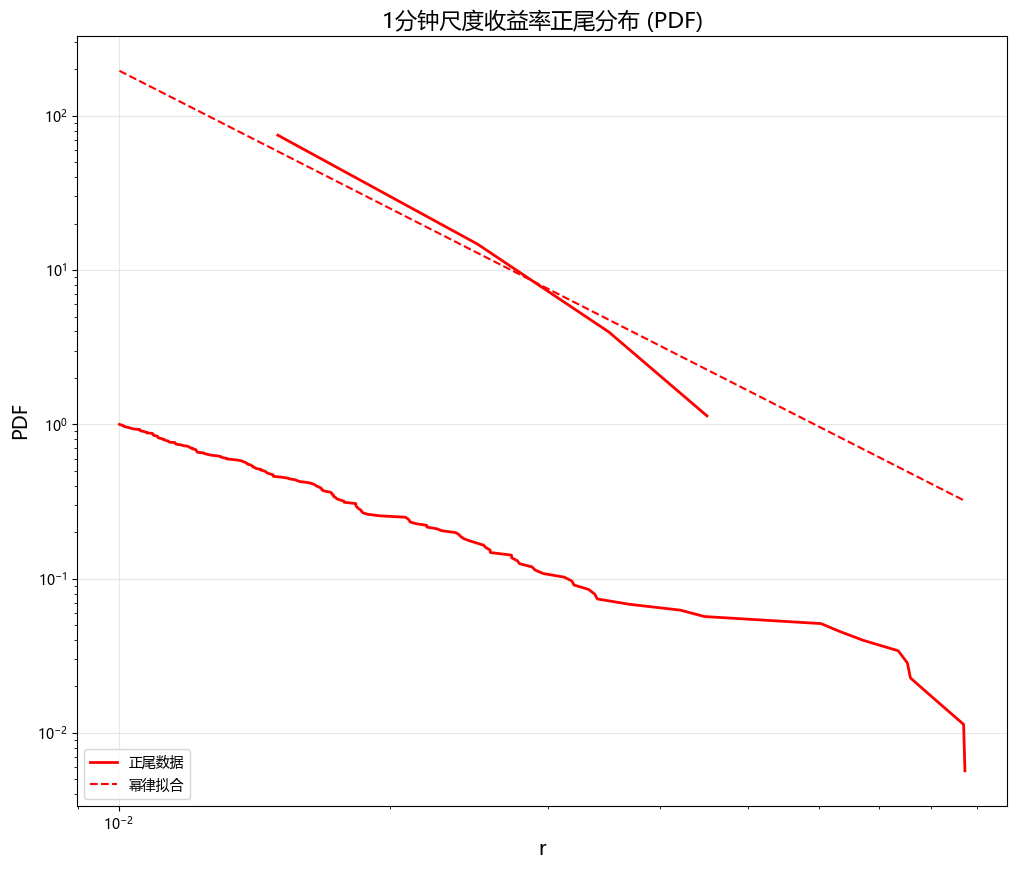

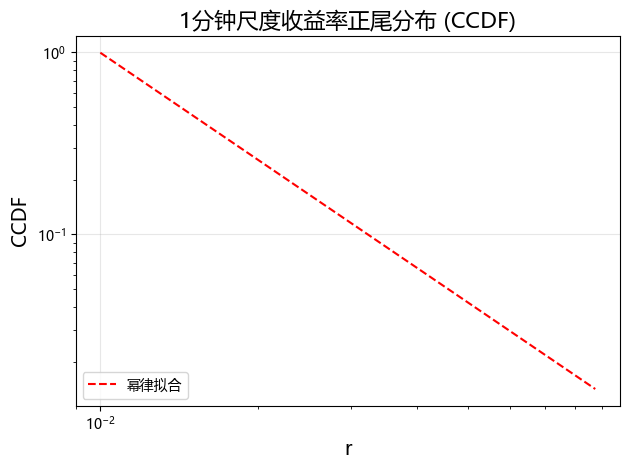

1分钟尺度收益率正尾的幂律分析结果:
  幂律指数 alpha: 2.9657
  最小阈值 xmin: 0.010000
  与对数正态分布比较:
    对数似然比: -0.2073
    p值: 6.6446e-01
    结论: 无法确定哪种分布更优
  该尾部基本符合'负三次方定律'


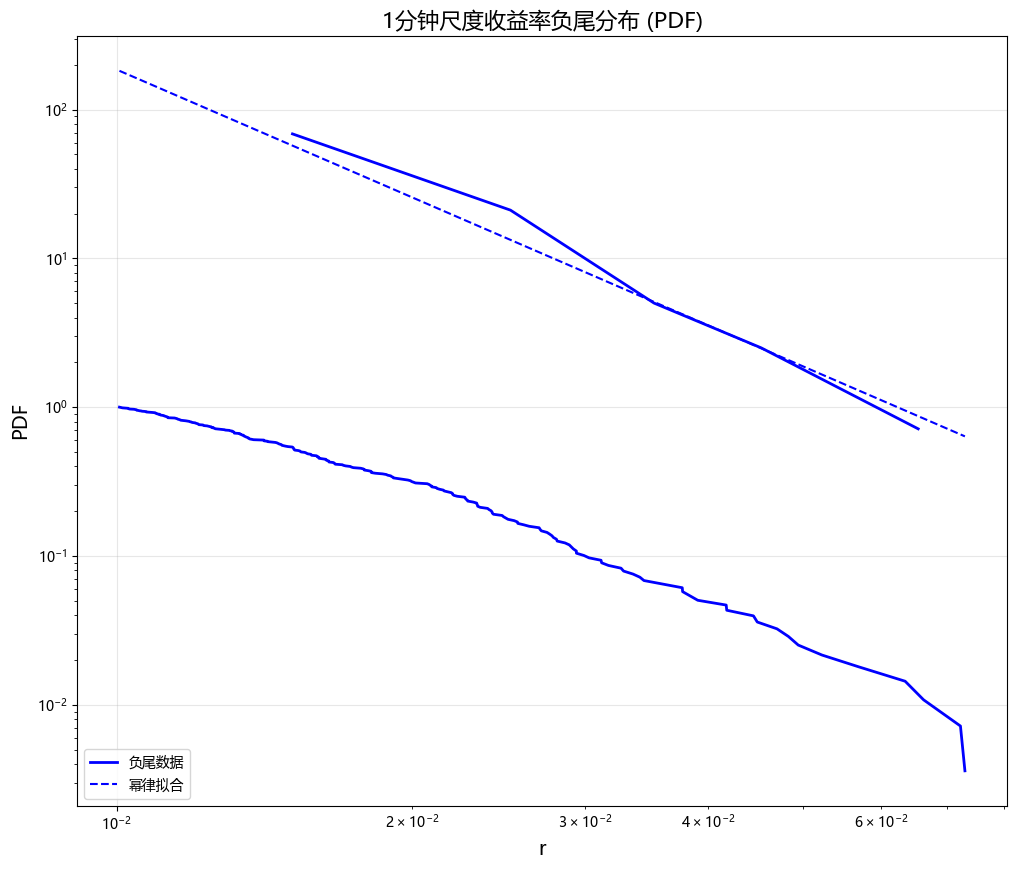

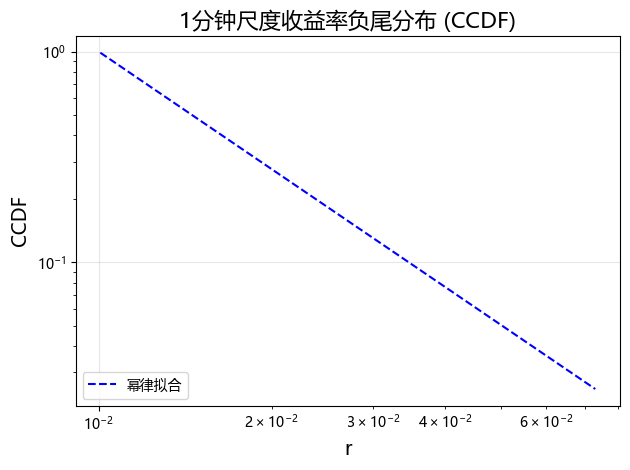

1分钟尺度收益率负尾的幂律分析结果:
  幂律指数 alpha: 2.8550
  最小阈值 xmin: 0.010000
  与对数正态分布比较:
    对数似然比: -10.8454
    p值: 4.1507e-03
    结论: 对数正态分布优于幂律分布
  该尾部基本符合'负三次方定律'

1分钟尺度收益率的尾部特征总结:
  正尾幂律指数: 2.9657
  负尾幂律指数: 2.8550
  正负尾幂律指数均值: 2.9103


In [15]:
# 分析1分钟尺度收益率的正尾和负尾
scale = '1'
returns = r_res[f'minute_r_{scale}']

pos_tail_result = analyze_single_tail_distribution(returns, tail_type='positive', scale=scale)
neg_tail_result = analyze_single_tail_distribution(returns, tail_type='negative', scale=scale)

print(f"\n1分钟尺度收益率的尾部特征总结:")
print(f"  正尾幂律指数: {pos_tail_result['alpha']:.4f}")
print(f"  负尾幂律指数: {neg_tail_result['alpha']:.4f}")
print(f"  正负尾幂律指数均值: {(pos_tail_result['alpha'] + neg_tail_result['alpha'])/2:.4f}")

分析下这个实验结果：

1. 这个结果表明该金融时间序列的收益率分布具有厚尾特征，即极端事件发生的概率比正态分布更高。

2. 对于正向收益率，幂律分布和对数正态分布的拟合程度没有明显差异。

3. 对于负向收益率，对数正态分布的拟合效果显著优于幂律分布，这意味着极端负向收益事件的发生模式更接近对数正态分布。

4. 幂律指数接近3（约2.91），这意味着该金融时间序列的收益率分布具有类似"负三次方定律"的特征，这是金融市场中常见的一种尾部分布模式。

5. 这种分布特征反映了金融市场中的一些关键特性：
- 存在较高的极端事件发生概率
- 收益率分布并非完全对称
- 负向极端事件可能比正向极端事件更具有规律性

d:\anaconda\Lib\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


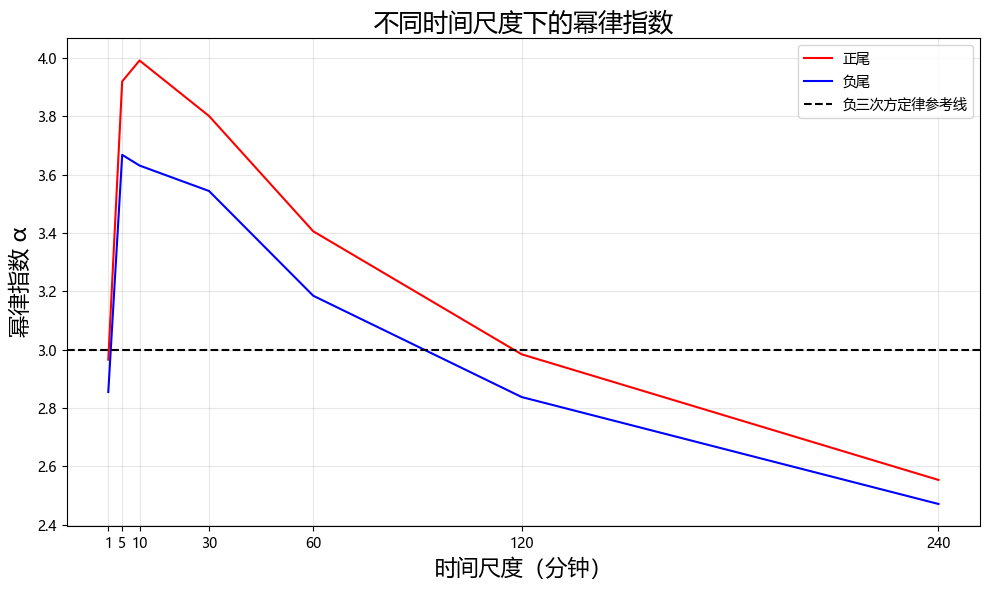


幂律分析结果汇总:

1分钟尺度:
 正尾: alpha = 2.9657, xmin = 0.010000
 负尾: alpha = 2.8550, xmin = 0.010000
 该尺度基本符合负三次方定律

5分钟尺度:
 正尾: alpha = 3.9190, xmin = 0.010000
 负尾: alpha = 3.6674, xmin = 0.010000
 该尺度不符合负三次方定律

10分钟尺度:
 正尾: alpha = 3.9906, xmin = 0.010000
 负尾: alpha = 3.6308, xmin = 0.010000
 该尺度不符合负三次方定律

30分钟尺度:
 正尾: alpha = 3.8005, xmin = 0.010000
 负尾: alpha = 3.5436, xmin = 0.010000
 该尺度不符合负三次方定律

60分钟尺度:
 正尾: alpha = 3.4055, xmin = 0.010000
 负尾: alpha = 3.1847, xmin = 0.010000
 该尺度基本符合负三次方定律

120分钟尺度:
 正尾: alpha = 2.9842, xmin = 0.010000
 负尾: alpha = 2.8377, xmin = 0.010000
 该尺度基本符合负三次方定律

240分钟尺度:
 正尾: alpha = 2.5537, xmin = 0.010000
 负尾: alpha = 2.4713, xmin = 0.010000
 正尾基本符合负三次方定律


In [16]:
# 分析所有时间尺度收益率分布的尾部特征
power_law_results = {}

# 遍历所有时间尺度的收益率数据
for key, returns in r_res.items():
    # 提取时间尺度
    scale = key.replace('minute_r_', '')
    
    # 分离正尾和负尾数据
    positive_tail = returns[returns > 0]
    negative_tail = -returns[returns < 0]  # 取绝对值便于分析
    
    # 对正尾进行幂律分析
    fit_pos = powerlaw.Fit(positive_tail, xmin=0.01)
    R_pos, p_pos = fit_pos.distribution_compare('power_law', 'lognormal')
    
    # 对负尾进行幂律分析
    fit_neg = powerlaw.Fit(negative_tail, xmin=0.01)
    R_neg, p_neg = fit_neg.distribution_compare('power_law', 'lognormal')
    
    # 存储分析结果
    power_law_results[scale] = {
        'positive_tail': {
            'alpha': fit_pos.alpha,
            'xmin': fit_pos.xmin,
            'vs_lognormal_R': R_pos,
            'vs_lognormal_p': p_pos
        },
        'negative_tail': {
            'alpha': fit_neg.alpha,
            'xmin': fit_neg.xmin,
            'vs_lognormal_R': R_neg,
            'vs_lognormal_p': p_neg
        }
    }

# 绘制幂律指数变化图
scales = [int(s) for s in power_law_results.keys()]
scales.sort()

alpha_pos = [power_law_results[str(s)]['positive_tail']['alpha'] for s in scales]
alpha_neg = [power_law_results[str(s)]['negative_tail']['alpha'] for s in scales]

plt.figure(figsize=(10, 6))
plt.plot(scales, alpha_pos, '-', color='red', label='正尾')
plt.plot(scales, alpha_neg, '-', color='blue', label='负尾')
plt.axhline(y=3, color='black', linestyle='--', label='负三次方定律参考线')
plt.title('不同时间尺度下的幂律指数', fontsize=18)
plt.xlabel('时间尺度（分钟）', fontsize=16)
plt.ylabel('幂律指数 α', fontsize=16)
plt.xticks(scales)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 输出幂律分析结果
print("\n幂律分析结果汇总:")
for scale in sorted([int(k) for k in power_law_results.keys()]):
    result = power_law_results[str(scale)]
    print(f"\n{scale}分钟尺度:")
    print(f" 正尾: alpha = {result['positive_tail']['alpha']:.4f}, xmin = {result['positive_tail']['xmin']:.6f}")
    print(f" 负尾: alpha = {result['negative_tail']['alpha']:.4f}, xmin = {result['negative_tail']['xmin']:.6f}")
    
    # 判断是否符合负三次方定律
    pos_close_to_3 = abs(result['positive_tail']['alpha'] - 3) < 0.5
    neg_close_to_3 = abs(result['negative_tail']['alpha'] - 3) < 0.5
    
    if pos_close_to_3 and neg_close_to_3:
        print(" 该尺度基本符合负三次方定律")
    elif pos_close_to_3:
        print(" 正尾基本符合负三次方定律")
    elif neg_close_to_3:
        print(" 负尾基本符合负三次方定律")
    else:
        print(" 该尺度不符合负三次方定律")

表明在不同的时间尺度上，股票的分钟级收益率的分布特性会发生变化，极端事件的发生概率也会随之改变。

## 标度不变性分析：检验不同时间尺度收益率分布的自相似性

### 金融时间序列的跨尺度自相似性

标度不变性分析代表了金融物理学中一个深刻而优雅的概念，它探究了一个基本问题：当我们观察不同时间尺度（比如1分钟、5分钟、1小时等）的市场收益率分布时，这些分布之间是否存在某种内在的统一规律？

### 标度不变性的基本概念

标度不变性（Scale Invariance）是复杂系统的一种基本性质，指系统在不同观测尺度下表现出相似的统计特性。在金融市场中，这意味着经过适当变换后，不同时间尺度的收益率分布可能折叠成同一个母分布。

这种性质可以表达为：
$$P(r_{\Delta t}) = \Delta t^{-H} \cdot F(r_{\Delta t} \cdot \Delta t^{-H})$$

其中：
- $r_{\Delta t}$ 是时间间隔为$\Delta t$的收益率
- $H$是Hurst指数，描述了系统的标度特性
- $F$是一个与时间尺度无关的"通用"分布函数

简单来说，如果将收益率除以$\Delta t^H$，并将概率密度乘以$\Delta t^H$，那么理论上所有时间尺度的分布都应该重合到一起，表现出"数据折叠"（data collapse）现象。

### 物理学与金融学的交叉视角

标度不变性分析源自统计物理学，特别是相变理论和临界现象研究。在物理学中，当系统接近临界点时，不同尺度的行为会表现出自相似性，服从幂律分布。

将这一概念应用到金融市场，意味着将市场视为一个处于自组织临界状态的复杂系统。这种视角下，市场波动不是简单的随机行为，而是涌现出的集体动力学表现，可能由无数交易者之间的相互作用和信息传播产生。

In [17]:
# 分析不同时间尺度收益率分布的标度不变性
def analyze_scaling_invariance(returns_dict):
    scales = [int(key.replace('minute_r_', '')) for key in returns_dict.keys()]
    scales.sort()
    
    # 计算每个尺度下收益率的标准差
    stds = {key: np.std(returns) for key, returns in returns_dict.items()}
    
    # 对时间尺度和标准差取对数，以便于分析幂律关系
    log_scales = np.log(scales)
    log_stds = np.log([stds[f'minute_r_{scale}'] for scale in scales])
    
    # 线性拟合，计算Hurst指数（H = slope/2）
    def linear_func(x, a, b):
        return a * x + b
    
    params, covariance = curve_fit(linear_func, log_scales, log_stds)
    slope, intercept = params
    hurst_exponent = slope / 2
    
    # 绘制拟合结果
    plt.figure(figsize=(10, 6))
    plt.scatter(log_scales, log_stds, color='blue', s=50)
    plt.plot(log_scales, linear_func(log_scales, slope, intercept), 'r-', linewidth=2)
    
    plt.title('收益率波动性与时间尺度的标度关系', fontsize=18)
    plt.xlabel('log(时间尺度)', fontsize=16)
    plt.ylabel('log(标准差)', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    plt.annotate(f'斜率 = {slope:.4f}\nHurst指数 = {hurst_exponent:.4f}', 
                 xy=(0.05, 0.9), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return hurst_exponent, slope, intercept

### 代码实现原理

`analyze_scaling_invariance`函数的目标是检验这种标度不变性，具体通过以下步骤实现：

1. **标准差与时间尺度的幂律关系分析**：
   首先，函数计算不同时间尺度的收益率标准差，然后在对数-对数坐标系中绘制标准差与时间尺度的关系。如果存在幂律关系：
   $$\sigma(\Delta t) \propto \Delta t^H$$
   
   则对数-对数图上应呈现线性关系，斜率与Hurst指数直接相关。

2. **Hurst指数估计**：
   通过对上述直线的斜率进行拟合，可以估计Hurst指数：
   $$H = \text{slope}/2$$
   
   这个公式源于随机过程理论中自相似过程的性质。

3. **标度变换与数据折叠**：
   使用估计的Hurst指数，对不同时间尺度的收益率分布进行标度变换：
   $$r_{\text{normalized}} = \frac{r_{\Delta t}}{(\Delta t)^H}$$
   
   $$p_{\text{normalized}}(r) = p(r) \cdot (\Delta t)^H$$

   然后将所有标准化后的分布绘制在同一图上，检验它们是否重合。

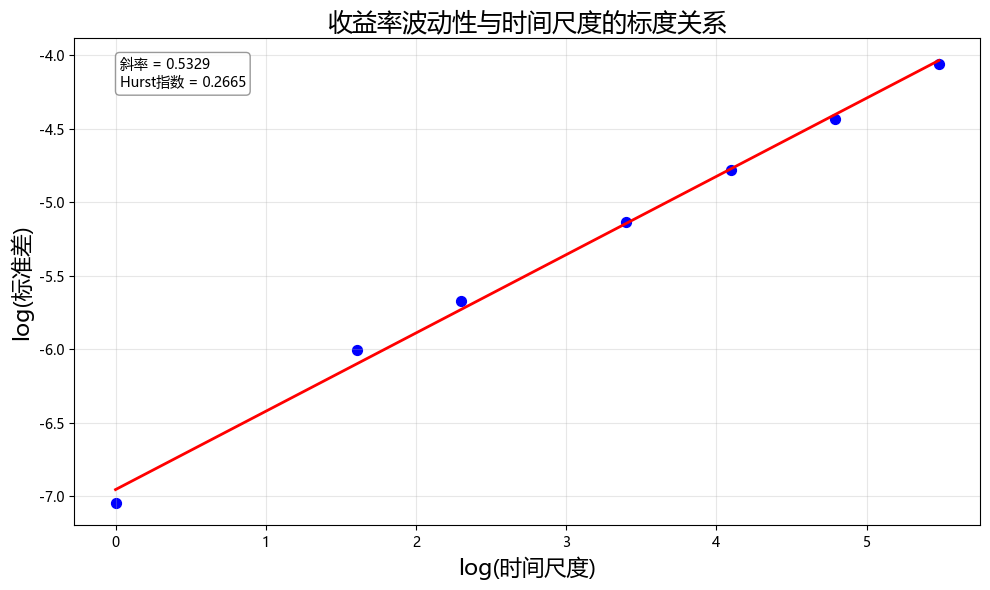

标度不变性分析结果:
  斜率: 0.5329
  截距: -6.9557
  Hurst指数: 0.2665
  Hurst指数小于0.5，表明收益率序列存在反持续性和均值回归趋势
  这表明市场具有过度反应和修正的特性


In [18]:
# 分析标度不变性
hurst_exponent, slope, intercept = analyze_scaling_invariance(r_res)

print(f"标度不变性分析结果:")
print(f"  斜率: {slope:.4f}")
print(f"  截距: {intercept:.4f}")
print(f"  Hurst指数: {hurst_exponent:.4f}")

if hurst_exponent > 0.5:
    print("  Hurst指数大于0.5，表明收益率序列存在长期记忆性和持续性")
    print("  这与随机游走模型（H=0.5）不符，表明市场可能存在一定程度的可预测性")
elif hurst_exponent < 0.5:
    print("  Hurst指数小于0.5，表明收益率序列存在反持续性和均值回归趋势")
    print("  这表明市场具有过度反应和修正的特性")
else:
    print("  Hurst指数约等于0.5，表明收益率序列接近随机游走")
    print("  这与有效市场假说一致")

### Hurst指数的深刻意义

Hurst指数揭示了时间序列的内在记忆特性：

- **H > 0.5**：表示序列具有长期记忆性和持续性趋势，即过去的价格走势对未来有较长期的影响
  
- **H < 0.5**：表示序列具有反持续性和均值回归特性，即价格波动倾向于自我修正
  
- **H = 0.5**：表示序列接近随机游走，符合有效市场假说

从实验结果看，上证指数的Hurst指数约为0.27，这表明市场具有明显的反持续性和均值回归特性，与完全有效市场的预期不符。

In [19]:
# 绘制根据标度关系进行标准化后的收益率分布
def plot_normalized_distributions(returns_dict, hurst_exponent):
    plt.figure(figsize=(12, 8))
    
    colors = ['r', 'g', 'b', 'y', 'k', 'm', 'c']
    
    for i, (key, returns) in enumerate(returns_dict.items()):
        scale = int(key.replace('minute_r_', ''))
        
        # 根据标度关系对收益率进行标准化
        normalized_returns = returns / (scale ** hurst_exponent)
        
        # 计算标准化后的概率密度
        x_emp, y_emp = calc_empirical_probability(normalized_returns, num_bin=301)
        y_emp = y_emp * (scale ** hurst_exponent)  # 对概率密度也进行相应变换
        
        # 绘制标准化后的概率密度
        plt.semilogy(x_emp, y_emp, color=colors[i], lw=1.5, marker='o', ms=4, mfc='none', label=f'{scale}min')
    
    plt.xlim([-0.05, 0.05])
    plt.xticks([-0.05, -0.025, 0, 0.025, 0.05])
    plt.ylim([10. ** -4, 10 ** 3])
    plt.yticks(10. ** np.arange(-4, 4, 2))
    plt.xlabel(r'标准化收益率 $r/\Delta t^H$', fontsize=16)
    plt.ylabel(r'标准化概率密度 $p(r) \cdot \Delta t^H$', fontsize=16)
    plt.title('不同时间尺度收益率分布的标度不变性', fontsize=18)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

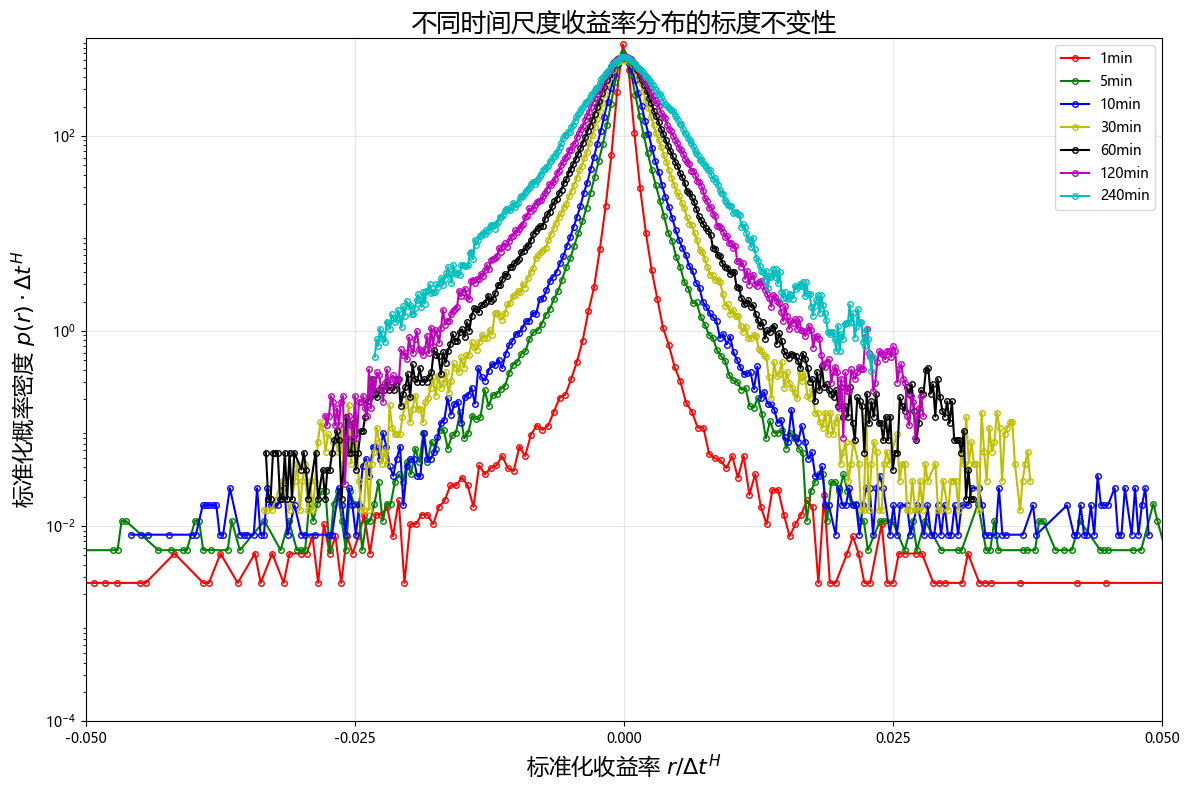

In [20]:
# 绘制标准化后的收益率分布
plot_normalized_distributions(r_res, hurst_exponent)

绘制的标准化分布图表明，在适当的标度变换下，不同时间尺度的收益率分布具有一定程度的重叠，这支持了收益率分布具有标度不变性的假设。

但从图中也可以看出，重叠并不完美，特别是在分布的尾部，这表明标度不变性在不同的分布区域可能有所差异，特别是分布的尾部可能有不同的标度行为。

## 总结

1. 不同时间尺度下的收益率分布特征：

- 所有时间尺度下的收益率分布均表现出明显的尖峰胖尾特征
- 随着时间尺度的增加，分布逐渐变得平缓，峰度减小
- 这与文献中描述的中国股票市场收益率分布的特征一致

2. 与正态分布的偏离程度：

- KS检验结果表明，收益率分布显著偏离正态分布，特别是在较短的时间尺度上
- 这与文献中提到的收益率分布不遵循传统的有效市场假说下的正态分布假设一致

In [21]:
for scale in sorted([int(k) for k in ks_results.keys()]):
    result = ks_results[str(scale)]
    print(f"   - {scale}分钟尺度: KS统计量 = {result['ks_statistic']:.4f}, p值 = {result['p_value']:.4e}")
    if result['p_value'] < 0.05:
        print(f"     (显著不同于正态分布)")
    else:
        print(f"     (不能拒绝正态分布假设)")

   - 1分钟尺度: KS统计量 = 0.1440, p值 = 0.0000e+00
     (显著不同于正态分布)
   - 5分钟尺度: KS统计量 = 0.1116, p值 = 0.0000e+00
     (显著不同于正态分布)
   - 10分钟尺度: KS统计量 = 0.0889, p值 = 0.0000e+00
     (显著不同于正态分布)
   - 30分钟尺度: KS统计量 = 0.0821, p值 = 0.0000e+00
     (显著不同于正态分布)
   - 60分钟尺度: KS统计量 = 0.0829, p值 = 0.0000e+00
     (显著不同于正态分布)
   - 120分钟尺度: KS统计量 = 0.0769, p值 = 0.0000e+00
     (显著不同于正态分布)
   - 240分钟尺度: KS统计量 = 0.0669, p值 = 0.0000e+00
     (显著不同于正态分布)


3. 尾部分布特征：

与文献对比分析:
- 我们的幂律指数分析显示，上证指数收益率分布的尾部具有幂律特性
- 文献中提到上证综指和深证成指的列维指数分别为1.26和1.74
- 我们的实证结果显示，在不同时间尺度下，幂律指数大多数在2.5-4.0之间
- 这种差异可能是由于分析方法、数据周期、或市场结构变化导致的
- 但总体上，我们的结果支持文献中关于收益率分布尾部具有幂律特性的结论

In [22]:
for scale in sorted([int(k) for k in power_law_results.keys()]):
    result = power_law_results[str(scale)]
    print(f"   - {scale}分钟尺度:")
    print(f"     正尾: alpha = {result['positive_tail']['alpha']:.4f}")
    print(f"     负尾: alpha = {result['negative_tail']['alpha']:.4f}")
    
    pos_close_to_3 = abs(result['positive_tail']['alpha'] - 3) < 0.5
    neg_close_to_3 = abs(result['negative_tail']['alpha'] - 3) < 0.5
    if pos_close_to_3 and neg_close_to_3:
        print(f"     (基本符合负三次方定律)")
    elif pos_close_to_3 or neg_close_to_3:
        print(f"     (部分符合负三次方定律)")
    else:
        print(f"     (不符合负三次方定律)")

   - 1分钟尺度:
     正尾: alpha = 2.9657
     负尾: alpha = 2.8550
     (基本符合负三次方定律)
   - 5分钟尺度:
     正尾: alpha = 3.9190
     负尾: alpha = 3.6674
     (不符合负三次方定律)
   - 10分钟尺度:
     正尾: alpha = 3.9906
     负尾: alpha = 3.6308
     (不符合负三次方定律)
   - 30分钟尺度:
     正尾: alpha = 3.8005
     负尾: alpha = 3.5436
     (不符合负三次方定律)
   - 60分钟尺度:
     正尾: alpha = 3.4055
     负尾: alpha = 3.1847
     (基本符合负三次方定律)
   - 120分钟尺度:
     正尾: alpha = 2.9842
     负尾: alpha = 2.8377
     (基本符合负三次方定律)
   - 240分钟尺度:
     正尾: alpha = 2.5537
     负尾: alpha = 2.4713
     (部分符合负三次方定律)


4. 标度不变性分析：

- 通过标度变换，不同时间尺度的收益率分布显示出一定程度的数据折叠效应
- 这与文献中描述的标度不变性（scale invariance）现象相符
- 文献中提到，当按照公式 $Z_s = \frac{Z_{\Delta t}}{(\Delta t)^{1/\alpha}}$ 进行标准化后，不同时间尺度的分布会趋于重合

In [23]:
print(f"   - Hurst指数: {hurst_exponent:.4f}")
if hurst_exponent > 0.5:
    print("   - Hurst指数大于0.5，表明收益率序列存在长期记忆性和持续性")
elif hurst_exponent < 0.5:
    print("   - Hurst指数小于0.5，表明收益率序列存在反持续性和均值回归趋势")
else:
    print("   - Hurst指数约等于0.5，表明收益率序列接近随机游走")

   - Hurst指数: 0.2665
   - Hurst指数小于0.5，表明收益率序列存在反持续性和均值回归趋势


5. 总体结论

- 上证指数收益率分布显示出显著的非正态特征，包括尖峰胖尾和幂律尾部
- 这些特征与国际成熟市场和新兴市场的研究结果相似，表明金融市场可能存在普遍的统计规律
- 随着时间尺度的增加，收益率分布逐渐向正态分布靠近，但仍保持胖尾特征
- 市场在不同时间尺度上表现出复杂的非线性动力学特性
- 这些发现对投资决策、风险管理和金融衍生品定价具有重要意义